In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import h5py
from tqdm import tqdm
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.optimize import root_scalar
import tarfile

In [91]:
!ls ../Data/Sims/

Astrid	   IllustrisTNG     SIMBA     Swift-EAGLE
Astrid_DM  IllustrisTNG_DM  SIMBA_DM  Swift-EAGLE_DM


# Astrid

In [9]:
simu = 'Astrid'

In [ ]:
isim = 2
box_size = 25 # MPc/h

for isim in range(99):
    print('Analizando simu ' + str(isim))
    # Busquemos los halos
    f_catalog  = '../Data/FOF_Subfind/' + simu + '/L25n256/LH/LH_' + str(isim) + '/groups_090.hdf5'
    f = h5py.File(f_catalog, 'r')

    # Seleccionemos los grupos con masas mayores a 1e13.5
    halo_ind = np.where(np.log10(f['Group/GroupMass'][()] * 1e10) > 13.5)[0]

    if len(halo_ind) > 0:
        # Seleccionemos las galaxias que pertenecen a cada halo
        gal_ind = np.where(f['Subhalo/SubhaloGrNr'][()] == halo_ind[0])[0]
    
        # Chequiamos que esten todas las galaxias
        f['Group/GroupNsubs'][()][halo_ind[0]] == len(gal_ind)
    
        # Buscamos el parent
        sublink = h5py.File('../Data/SubLink_gal/' + simu + '/L25n256/LH/LH_' + str(isim) + '/tree_extended.hdf5', 'r')
    
    
        halo_properties = {}
        for haloIndice in halo_ind:
            halo_properties['haloID:' + str(haloIndice)] = {}
            
            # Indices de las galaxias pertenecientes a un halo a un dado snapshot
            gal_indices = np.where((sublink['SnapNum'][()] == 90) & (sublink['SubhaloGrNr'][()] == haloIndice))[0]
            
            # Primero busquemos la posicion y velocidad del grupo
            FirstSubhaloInFOFGroupID = sublink['FirstSubhaloInFOFGroupID'][gal_indices][0]
            indice = np.where(sublink['SubhaloID'] == FirstSubhaloInFOFGroupID)[0][0]
            FirstProgID = sublink['FirstProgenitorID'][indice]
                
            mainHalo_dict = {}
            groupID = []
            pos = []
            vel = []
            while FirstProgID > 0:
                groupID = sublink['SubhaloGrNr'][indice]
                snap = sublink['SnapNum'][indice]
                
                halo_pos = sublink['GroupPos'][indice] / 1e3 # Mpc/h
                halo_vel = sublink['GroupVel'][indice] # km/s
                
                indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                mainHalo_dict['snap:' + str(snap)] = {}
                mainHalo_dict['snap:' + str(snap)]['groupID'] = groupID
                mainHalo_dict['snap:' + str(snap)]['pos'] = np.array(halo_pos)
                mainHalo_dict['snap:' + str(snap)]['vel'] = np.array(halo_vel)
         
            halo_properties['haloID:' + str(haloIndice)]['mainHalo'] = mainHalo_dict
            
            # Now we analyze the galaxies that belong to the halo
            galIds = sublink['SubhaloID'][gal_indices]
            properties = {}
            print('Analizando halo: ' + str(haloIndice) + ' con ' + str(len(galIds)) + ' galaxias')
            for i, galid in tqdm(enumerate(galIds)):
                indice = gal_indices[i]
            
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                aux_dict = {}
                groupID = []
                snap = []
                groupR200 = []
                groupM200 = []
                dist = []
                rel_vel = []
                pos = []
                vel = []
                GasMass = []
                StarsMass = []
                DMMass = []
                SFR = []
                HMR = []
                while FirstProgID > 0:
                    groupID.append(sublink['SubhaloGrNr'][indice])
                    snap.append(sublink['SnapNum'][indice])
                    groupR200.append(sublink['Group_R_Crit200'][indice][()] / 1e3) # Mpc/h
                    groupM200.append(sublink['Group_M_Crit200'][indice][()] * 1e10) # Msun/h
        
                    try:
                        halo_pos = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['pos'] #sublink['GroupPos'][indice][0]
                        halo_vel = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['vel'] # sublink['GroupVel'][indice][0]
                    except:
                        pass
                    subhalo_pos = sublink['SubhaloPos'][indice] / 1e3 # Mpc/h
                    subhalo_vel = sublink['SubhaloVel'][indice] # km/s
        
                    # Periodicity
                    ind = np.where(np.abs(subhalo_pos - halo_pos) > box_size/2)[0]
                    if len(ind) > 0:
                        subhalo_pos[ind] = subhalo_pos[ind] - np.sign(subhalo_pos - halo_pos)[ind] * box_size
        
                    dist.append( np.sqrt(np.sum((subhalo_pos - halo_pos)**2)) )
                    rel_vel.append( np.dot((subhalo_pos - halo_pos), (subhalo_vel - halo_vel)) )
        
                    GasMass.append( sublink['SubhaloMassType'][indice][0] *  1e10 ) # Msun/h
                    StarsMass.append( sublink['SubhaloMassType'][indice][4] *  1e10 ) # Msun/h
                    DMMass.append( sublink['SubhaloMassType'][indice][1] *  1e10 ) # Msun/h
                    SFR.append( sublink['SubhaloSFR'][indice] ) # Msun/yr
                    HMR.append( sublink['SubhaloHalfmassRad'][indice] / 1e3 ) # MPc/h
                    
                    indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                    FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                aux_dict['groupID'] = groupID
                aux_dict['snap'] = snap
                aux_dict['groupR200'] = groupR200
                aux_dict['groupM200'] = groupM200
                aux_dict['dist'] = dist
                aux_dict['rel_vel'] = rel_vel
                aux_dict['subhalo_pos'] = subhalo_pos
                aux_dict['subhalo_vel'] = subhalo_vel
                aux_dict['GasMass'] = GasMass
                aux_dict['StarsMass'] = StarsMass
                aux_dict['DMMass'] = DMMass
                aux_dict['SFR'] = SFR
                aux_dict['HMR'] = HMR
                
                properties['galID:' + str(galid)] = aux_dict
                properties['FirstSubhaloInFOFGroupID'] = FirstSubhaloInFOFGroupID
            halo_properties['haloID:' + str(haloIndice)]['galaxies'] = properties
    
        with open(f'{simu}_LH_{isim}.pkl', 'wb') as f:
            pickle.dump(halo_properties, f)

Analizando simu 0
Analizando halo: 0 con 245 galaxias


245it [02:12,  1.85it/s]


Analizando halo: 1 con 263 galaxias


263it [02:23,  1.84it/s]


Analizando halo: 2 con 172 galaxias


172it [01:36,  1.79it/s]


Analizando halo: 3 con 157 galaxias


157it [01:23,  1.88it/s]


Analizando simu 1
Analizando simu 2
Analizando halo: 0 con 413 galaxias


413it [03:23,  2.03it/s]


Analizando halo: 1 con 208 galaxias


208it [01:42,  2.03it/s]


Analizando halo: 2 con 145 galaxias


145it [01:09,  2.10it/s]


Analizando simu 3
Analizando halo: 0 con 407 galaxias


407it [03:06,  2.18it/s]


Analizando halo: 1 con 219 galaxias


219it [01:36,  2.26it/s]


Analizando halo: 2 con 185 galaxias


185it [01:26,  2.14it/s]


Analizando halo: 3 con 236 galaxias


236it [01:41,  2.32it/s]


Analizando simu 4
Analizando halo: 0 con 513 galaxias


513it [04:20,  1.97it/s]


Analizando halo: 1 con 242 galaxias


242it [02:19,  1.73it/s]


Analizando halo: 2 con 140 galaxias


140it [01:21,  1.73it/s]


Analizando simu 5
Analizando halo: 0 con 540 galaxias


540it [04:20,  2.07it/s]


Analizando halo: 1 con 255 galaxias


255it [02:10,  1.95it/s]


Analizando halo: 2 con 306 galaxias


306it [02:16,  2.24it/s]


Analizando halo: 3 con 173 galaxias


173it [01:23,  2.06it/s]


Analizando simu 6
Analizando halo: 0 con 461 galaxias


461it [02:19,  3.31it/s]


Analizando simu 7
Analizando halo: 0 con 610 galaxias


610it [05:23,  1.89it/s]


Analizando halo: 1 con 124 galaxias


124it [01:08,  1.82it/s]


Analizando halo: 2 con 110 galaxias


110it [00:56,  1.95it/s]


Analizando simu 8
Analizando simu 9
Analizando halo: 0 con 240 galaxias


240it [01:19,  3.04it/s]


Analizando simu 10
Analizando halo: 0 con 273 galaxias


273it [01:40,  2.72it/s]


Analizando halo: 1 con 202 galaxias


202it [01:14,  2.72it/s]


Analizando halo: 2 con 141 galaxias


141it [00:49,  2.87it/s]


Analizando simu 11
Analizando simu 12
Analizando halo: 0 con 189 galaxias


189it [00:47,  3.96it/s]


Analizando simu 13
Analizando halo: 0 con 189 galaxias


189it [01:03,  2.97it/s]


Analizando halo: 1 con 212 galaxias


212it [01:06,  3.18it/s]


Analizando halo: 2 con 196 galaxias


196it [01:02,  3.13it/s]


Analizando simu 14
Analizando halo: 0 con 216 galaxias


216it [01:39,  2.16it/s]


Analizando simu 15
Analizando halo: 0 con 206 galaxias


206it [01:15,  2.74it/s]


Analizando simu 16
Analizando simu 17
Analizando halo: 0 con 148 galaxias


148it [00:55,  2.66it/s]


Analizando simu 18
Analizando simu 19
Analizando halo: 0 con 503 galaxias


503it [01:58,  4.23it/s]


Analizando simu 20
Analizando halo: 0 con 203 galaxias


203it [01:23,  2.43it/s]


Analizando halo: 1 con 175 galaxias


175it [01:09,  2.50it/s]


Analizando halo: 2 con 133 galaxias


133it [00:52,  2.53it/s]


Analizando halo: 3 con 156 galaxias


156it [01:05,  2.40it/s]


Analizando simu 21
Analizando halo: 0 con 654 galaxias


654it [06:32,  1.67it/s]


Analizando halo: 1 con 170 galaxias


170it [01:51,  1.53it/s]


Analizando simu 22
Analizando halo: 0 con 388 galaxias


388it [02:57,  2.19it/s]


Analizando halo: 1 con 157 galaxias


157it [01:09,  2.25it/s]


Analizando simu 23
Analizando simu 24
Analizando halo: 0 con 252 galaxias


252it [01:16,  3.31it/s]


Analizando simu 25
Analizando halo: 0 con 218 galaxias


218it [01:06,  3.27it/s]


Analizando halo: 1 con 163 galaxias


163it [00:54,  3.01it/s]


Analizando simu 26
Analizando halo: 0 con 477 galaxias


477it [03:10,  2.50it/s]


Analizando halo: 1 con 335 galaxias


335it [02:10,  2.57it/s]


Analizando halo: 2 con 240 galaxias


240it [01:35,  2.52it/s]


Analizando simu 27
Analizando halo: 0 con 274 galaxias


274it [01:45,  2.61it/s]


Analizando simu 28
Analizando halo: 0 con 263 galaxias


263it [01:19,  3.31it/s]


Analizando simu 29
Analizando simu 30
Analizando halo: 0 con 331 galaxias


331it [01:40,  3.29it/s]


Analizando halo: 1 con 244 galaxias


244it [01:05,  3.72it/s]


Analizando simu 31
Analizando halo: 0 con 300 galaxias


300it [01:54,  2.63it/s]


Analizando halo: 1 con 150 galaxias


150it [00:54,  2.74it/s]


Analizando halo: 2 con 100 galaxias


100it [00:38,  2.57it/s]


Analizando halo: 3 con 125 galaxias


125it [00:44,  2.80it/s]


Analizando simu 32
Analizando halo: 0 con 303 galaxias


303it [02:54,  1.73it/s]


Analizando halo: 1 con 301 galaxias


301it [02:56,  1.71it/s]


Analizando halo: 2 con 277 galaxias


277it [02:34,  1.80it/s]


Analizando halo: 3 con 126 galaxias


126it [01:16,  1.65it/s]


Analizando simu 33
Analizando halo: 0 con 364 galaxias


364it [02:29,  2.44it/s]


Analizando simu 34
Analizando halo: 0 con 798 galaxias


798it [05:27,  2.44it/s]


Analizando halo: 1 con 180 galaxias


180it [01:15,  2.39it/s]


Analizando halo: 2 con 158 galaxias


158it [01:11,  2.22it/s]


Analizando halo: 3 con 128 galaxias


102it [00:46,  3.33it/s]

# TNG

In [89]:
simu = 'IllustrisTNG'
box_size = 25 # MPc/h

In [90]:
for isim in range(100):
    print('Analizando simu ' + str(isim))
    # Busquemos los halos
    f_catalog  = '../Data/FOF_Subfind/' + simu + '/L25n256/LH/LH_' + str(isim) + '/groups_090.hdf5'
    f = h5py.File(f_catalog, 'r')

    # Seleccionemos los grupos con masas mayores a 1e13.5
    halo_ind = np.where(np.log10(f['Group/GroupMass'][()] * 1e10) > 13.5)[0]

    if len(halo_ind) > 0:
        # Seleccionemos las galaxias que pertenecen a cada halo
        gal_ind = np.where(f['Subhalo/SubhaloGrNr'][()] == halo_ind[0])[0]
    
        # Chequiamos que esten todas las galaxias
        f['Group/GroupNsubs'][()][halo_ind[0]] == len(gal_ind)
    
        # Buscamos el parent
        sublink = h5py.File('../Data/SubLink_gal/' + simu + '/L25n256/LH/LH_' + str(isim) + '/tree_extended.hdf5', 'r')    
    
        halo_properties = {}
        for haloIndice in halo_ind:
            halo_properties['haloID:' + str(haloIndice)] = {}
            
            # Indices de las galaxias pertenecientes a un halo a un dado snapshot
            gal_indices = np.where((sublink['SnapNum'][()] == 33) & (sublink['SubhaloGrNr'][()] == haloIndice))[0]
            
            # Primero busquemos la posicion y velocidad del grupo
            FirstSubhaloInFOFGroupID = sublink['FirstSubhaloInFOFGroupID'][gal_indices][0]
            indice = np.where(sublink['SubhaloID'] == FirstSubhaloInFOFGroupID)[0][0]
            FirstProgID = sublink['FirstProgenitorID'][indice]
                
            mainHalo_dict = {}
            groupID = []
            pos = []
            vel = []
            while FirstProgID > 0:
                groupID = sublink['SubhaloGrNr'][indice]
                snap = sublink['SnapNum'][indice]
                
                halo_pos = sublink['GroupPos'][indice] / 1e3 # Mpc/h
                halo_vel = sublink['GroupVel'][indice] # km/s
                
                indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                mainHalo_dict['snap:' + str(snap)] = {}
                mainHalo_dict['snap:' + str(snap)]['groupID'] = groupID
                mainHalo_dict['snap:' + str(snap)]['pos'] = np.array(halo_pos)
                mainHalo_dict['snap:' + str(snap)]['vel'] = np.array(halo_vel)
         
            halo_properties['haloID:' + str(haloIndice)]['mainHalo'] = mainHalo_dict
            
            # Now we analyze the galaxies that belong to the halo
            galIds = sublink['SubhaloID'][gal_indices]
            properties = {}
            print('Analizando halo: ' + str(haloIndice) + ' con ' + str(len(galIds)) + ' galaxias')
            for i, galid in tqdm(enumerate(galIds)):
                indice = gal_indices[i]
            
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                aux_dict = {}
                groupID = []
                snap = []
                groupR200 = []
                groupM200 = []
                dist = []
                rel_vel = []
                pos = []
                vel = []
                GasMass = []
                StarsMass = []
                DMMass = []
                SFR = []
                HMR = []
                while FirstProgID > 0:
                    groupID.append(sublink['SubhaloGrNr'][indice])
                    snap.append(sublink['SnapNum'][indice])
                    groupR200.append(sublink['Group_R_Crit200'][indice][()] / 1e3) # Mpc/h
                    groupM200.append(sublink['Group_M_Crit200'][indice][()] * 1e10) # Msun/h
        
                    try:
                        halo_pos = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['pos'] #sublink['GroupPos'][indice][0]
                        halo_vel = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['vel'] # sublink['GroupVel'][indice][0]
                    except:
                        pass
                    subhalo_pos = sublink['SubhaloPos'][indice] / 1e3 # Mpc/h
                    subhalo_vel = sublink['SubhaloVel'][indice] # km/s
        
                    # Periodicity
                    ind = np.where(np.abs(subhalo_pos - halo_pos) > box_size/2)[0]
                    if len(ind) > 0:
                        subhalo_pos[ind] = subhalo_pos[ind] - np.sign(subhalo_pos - halo_pos)[ind] * box_size
        
                    dist.append( np.sqrt(np.sum((subhalo_pos - halo_pos)**2)) )
                    rel_vel.append( np.dot((subhalo_pos - halo_pos), (subhalo_vel - halo_vel)) )
        
                    GasMass.append( sublink['SubhaloMassType'][indice][0] *  1e10 ) # Msun/h
                    StarsMass.append( sublink['SubhaloMassType'][indice][4] *  1e10 ) # Msun/h
                    DMMass.append( sublink['SubhaloMassType'][indice][1] *  1e10 ) # Msun/h
                    SFR.append( sublink['SubhaloSFR'][indice] ) # Msun/yr
                    HMR.append( sublink['SubhaloHalfmassRad'][indice] / 1e3 ) # MPc/h
                    
                    indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                    FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                aux_dict['groupID'] = groupID
                aux_dict['snap'] = snap
                aux_dict['groupR200'] = groupR200
                aux_dict['groupM200'] = groupM200
                aux_dict['dist'] = dist
                aux_dict['rel_vel'] = rel_vel
                aux_dict['subhalo_pos'] = subhalo_pos
                aux_dict['subhalo_vel'] = subhalo_vel
                aux_dict['GasMass'] = GasMass
                aux_dict['StarsMass'] = StarsMass
                aux_dict['DMMass'] = DMMass
                aux_dict['SFR'] = SFR
                aux_dict['HMR'] = HMR
                
                properties['galID:' + str(galid)] = aux_dict
                properties['FirstSubhaloInFOFGroupID'] = FirstSubhaloInFOFGroupID
            halo_properties['haloID:' + str(haloIndice)]['galaxies'] = properties
    
        with open(f'{simu}_LH_{isim}.pkl', 'wb') as f:
            pickle.dump(halo_properties, f)

Analizando simu 0
Analizando halo: 0 con 74 galaxias


74it [00:08,  9.14it/s]


Analizando halo: 1 con 83 galaxias


83it [00:07, 10.69it/s]


Analizando simu 1
Analizando halo: 0 con 64 galaxias


64it [00:07,  8.57it/s]


Analizando halo: 1 con 84 galaxias


84it [00:08,  9.59it/s]


Analizando simu 2
Analizando halo: 0 con 312 galaxias


312it [00:33,  9.29it/s]


Analizando halo: 1 con 111 galaxias


111it [00:12,  9.16it/s]


Analizando simu 3
Analizando simu 4
Analizando halo: 0 con 120 galaxias


120it [00:08, 14.51it/s]


Analizando simu 5
Analizando halo: 0 con 34 galaxias


34it [00:04,  7.87it/s]


Analizando simu 6
Analizando halo: 0 con 84 galaxias


84it [00:10,  8.07it/s]


Analizando halo: 1 con 97 galaxias


97it [00:09, 10.40it/s]


Analizando halo: 2 con 81 galaxias


81it [00:07, 10.70it/s]


Analizando simu 7
Analizando halo: 0 con 165 galaxias


165it [00:18,  8.92it/s]


Analizando halo: 1 con 74 galaxias


74it [00:07,  9.39it/s]


Analizando halo: 2 con 57 galaxias


57it [00:06,  9.50it/s]


Analizando halo: 3 con 57 galaxias


57it [00:05,  9.90it/s]


Analizando halo: 4 con 61 galaxias


61it [00:06, 10.03it/s]


Analizando halo: 5 con 32 galaxias


32it [00:03,  9.50it/s]


Analizando simu 8
Analizando halo: 0 con 330 galaxias


330it [00:36,  9.02it/s]


Analizando halo: 1 con 344 galaxias


344it [00:39,  8.78it/s]


Analizando halo: 2 con 157 galaxias


157it [00:16,  9.26it/s]


Analizando halo: 3 con 88 galaxias


88it [00:10,  8.47it/s]


Analizando simu 9
Analizando halo: 0 con 119 galaxias


119it [00:12,  9.37it/s]


Analizando halo: 1 con 98 galaxias


98it [00:09,  9.87it/s]


Analizando halo: 2 con 62 galaxias


62it [00:07,  7.89it/s]


Analizando simu 10
Analizando halo: 0 con 268 galaxias


268it [00:38,  6.96it/s]


Analizando halo: 1 con 73 galaxias


73it [00:08,  8.15it/s]


Analizando simu 11
Analizando halo: 0 con 176 galaxias


176it [00:19,  9.14it/s]


Analizando halo: 1 con 49 galaxias


49it [00:05,  9.05it/s]


Analizando halo: 2 con 68 galaxias


68it [00:07,  9.53it/s]


Analizando halo: 3 con 32 galaxias


32it [00:03,  9.12it/s]


Analizando halo: 4 con 23 galaxias


23it [00:02,  8.77it/s]


Analizando halo: 5 con 36 galaxias


36it [00:04,  8.89it/s]


Analizando simu 12
Analizando halo: 0 con 102 galaxias


102it [00:11,  8.56it/s]


Analizando halo: 1 con 63 galaxias


63it [00:08,  7.84it/s]


Analizando halo: 2 con 52 galaxias


52it [00:06,  8.61it/s]


Analizando halo: 3 con 29 galaxias


29it [00:03,  7.58it/s]


Analizando simu 13
Analizando halo: 0 con 273 galaxias


273it [00:32,  8.44it/s]


Analizando halo: 1 con 66 galaxias


66it [00:07,  9.43it/s]


Analizando halo: 2 con 84 galaxias


84it [00:09,  9.17it/s]


Analizando halo: 3 con 95 galaxias


95it [00:09,  9.56it/s]


Analizando simu 14
Analizando simu 15
Analizando halo: 0 con 87 galaxias


87it [00:10,  7.96it/s]


Analizando simu 16
Analizando halo: 0 con 196 galaxias


196it [00:20,  9.62it/s]


Analizando simu 17
Analizando simu 18
Analizando simu 19
Analizando halo: 0 con 34 galaxias


34it [00:04,  6.81it/s]


Analizando simu 20
Analizando simu 21
Analizando halo: 0 con 217 galaxias


217it [00:27,  7.94it/s]


Analizando halo: 1 con 94 galaxias


94it [00:11,  8.41it/s]


Analizando simu 22
Analizando halo: 0 con 117 galaxias


117it [00:12,  9.63it/s]


Analizando simu 23
Analizando halo: 0 con 83 galaxias


83it [00:10,  8.21it/s]


Analizando halo: 1 con 90 galaxias


90it [00:09,  9.20it/s]


Analizando simu 24
Analizando halo: 0 con 159 galaxias


159it [00:17,  9.30it/s]


Analizando simu 25
Analizando halo: 0 con 139 galaxias


139it [00:12, 11.58it/s]


Analizando simu 26
Analizando halo: 0 con 266 galaxias


266it [00:27,  9.82it/s]


Analizando simu 27
Analizando halo: 0 con 142 galaxias


142it [00:15,  8.92it/s]


Analizando simu 28
Analizando halo: 0 con 124 galaxias


124it [00:16,  7.61it/s]


Analizando halo: 1 con 130 galaxias


130it [00:16,  7.94it/s]


Analizando halo: 2 con 86 galaxias


86it [00:10,  8.26it/s]


Analizando halo: 3 con 52 galaxias


52it [00:06,  7.43it/s]


Analizando halo: 4 con 78 galaxias


78it [00:09,  7.99it/s]


Analizando simu 29
Analizando halo: 0 con 68 galaxias


68it [00:07,  9.09it/s]


Analizando simu 30
Analizando simu 31
Analizando halo: 0 con 154 galaxias


154it [00:18,  8.15it/s]


Analizando halo: 1 con 74 galaxias


74it [00:08,  8.97it/s]


Analizando halo: 2 con 65 galaxias


65it [00:06,  9.58it/s]


Analizando halo: 3 con 44 galaxias


44it [00:04,  9.00it/s]


Analizando simu 32
Analizando halo: 0 con 389 galaxias


389it [00:54,  7.14it/s]


Analizando halo: 1 con 105 galaxias


105it [00:13,  7.56it/s]


Analizando halo: 2 con 92 galaxias


92it [00:11,  8.33it/s]


Analizando halo: 3 con 112 galaxias


112it [00:12,  8.85it/s]


Analizando halo: 4 con 116 galaxias


116it [00:13,  8.90it/s]


Analizando halo: 5 con 67 galaxias


67it [00:07,  8.74it/s]


Analizando simu 33
Analizando halo: 0 con 105 galaxias


105it [00:09, 10.94it/s]


Analizando simu 34
Analizando halo: 0 con 230 galaxias


230it [00:26,  8.54it/s]


Analizando halo: 1 con 116 galaxias


116it [00:13,  8.90it/s]


Analizando halo: 2 con 69 galaxias


69it [00:07,  9.53it/s]


Analizando simu 35
Analizando halo: 0 con 215 galaxias


215it [00:24,  8.90it/s]


Analizando halo: 1 con 193 galaxias


193it [00:20,  9.42it/s]


Analizando simu 36
Analizando halo: 0 con 285 galaxias


285it [00:31,  9.11it/s]


Analizando halo: 1 con 37 galaxias


37it [00:03,  9.40it/s]


Analizando simu 37
Analizando halo: 0 con 113 galaxias


113it [00:13,  8.42it/s]


Analizando halo: 1 con 54 galaxias


54it [00:05,  9.54it/s]


Analizando simu 38
Analizando halo: 0 con 53 galaxias


53it [00:05,  8.99it/s]


Analizando halo: 1 con 47 galaxias


47it [00:04,  9.74it/s]


Analizando halo: 2 con 63 galaxias


63it [00:06, 10.22it/s]


Analizando halo: 3 con 54 galaxias


54it [00:05, 10.48it/s]


Analizando simu 39
Analizando halo: 0 con 65 galaxias


65it [00:06, 10.67it/s]


Analizando simu 40
Analizando simu 41
Analizando halo: 0 con 190 galaxias


190it [00:23,  8.09it/s]


Analizando halo: 1 con 121 galaxias


121it [00:15,  7.99it/s]


Analizando halo: 2 con 96 galaxias


96it [00:11,  8.65it/s]


Analizando halo: 3 con 66 galaxias


66it [00:07,  8.66it/s]


Analizando halo: 4 con 72 galaxias


72it [00:08,  8.61it/s]


Analizando simu 42
Analizando halo: 0 con 155 galaxias


155it [00:18,  8.26it/s]


Analizando halo: 1 con 94 galaxias


94it [00:10,  9.00it/s]


Analizando halo: 2 con 58 galaxias


58it [00:06,  9.37it/s]


Analizando halo: 3 con 34 galaxias


34it [00:03,  9.16it/s]


Analizando halo: 4 con 28 galaxias


28it [00:02,  9.45it/s]


Analizando simu 43
Analizando simu 44
Analizando halo: 0 con 102 galaxias


102it [00:08, 12.18it/s]


Analizando simu 45
Analizando simu 46
Analizando halo: 0 con 331 galaxias


331it [00:34,  9.70it/s]


Analizando halo: 1 con 121 galaxias


121it [00:12,  9.83it/s]


Analizando halo: 2 con 57 galaxias


57it [00:05, 10.19it/s]


Analizando simu 47
Analizando halo: 0 con 183 galaxias


183it [00:19,  9.33it/s]


Analizando halo: 1 con 108 galaxias


108it [00:11,  9.47it/s]


Analizando halo: 2 con 102 galaxias


102it [00:10,  9.68it/s]


Analizando simu 48
Analizando halo: 0 con 402 galaxias


402it [00:48,  8.31it/s]


Analizando halo: 1 con 163 galaxias


163it [00:19,  8.19it/s]


Analizando halo: 2 con 124 galaxias


124it [00:14,  8.38it/s]


Analizando halo: 3 con 88 galaxias


88it [00:10,  8.17it/s]


Analizando halo: 4 con 60 galaxias


60it [00:07,  8.49it/s]


Analizando simu 49
Analizando halo: 0 con 158 galaxias


158it [00:17,  9.22it/s]


Analizando halo: 1 con 115 galaxias


115it [00:12,  9.41it/s]


Analizando halo: 2 con 41 galaxias


41it [00:04,  8.64it/s]


Analizando simu 50
Analizando halo: 0 con 122 galaxias


122it [00:13,  9.36it/s]


Analizando halo: 1 con 132 galaxias


132it [00:15,  8.80it/s]


Analizando simu 51
Analizando simu 52
Analizando halo: 0 con 53 galaxias


53it [00:05,  8.98it/s]


Analizando simu 53
Analizando halo: 0 con 205 galaxias


205it [00:21,  9.53it/s]


Analizando simu 54
Analizando halo: 0 con 118 galaxias


118it [00:12,  9.32it/s]


Analizando halo: 1 con 102 galaxias


102it [00:10,  9.91it/s]


Analizando simu 55
Analizando simu 56
Analizando simu 57
Analizando simu 58
Analizando halo: 0 con 104 galaxias


104it [00:10,  9.54it/s]


Analizando simu 59
Analizando halo: 0 con 182 galaxias


182it [00:23,  7.80it/s]


Analizando halo: 1 con 109 galaxias


109it [00:13,  8.13it/s]


Analizando halo: 2 con 92 galaxias


92it [00:11,  8.21it/s]


Analizando halo: 3 con 88 galaxias


88it [00:10,  8.49it/s]


Analizando halo: 4 con 69 galaxias


69it [00:07,  9.17it/s]


Analizando halo: 5 con 77 galaxias


77it [00:09,  8.35it/s]


Analizando simu 60
Analizando halo: 0 con 311 galaxias


311it [00:37,  8.40it/s]


Analizando simu 61
Analizando halo: 0 con 141 galaxias


141it [00:17,  7.91it/s]


Analizando halo: 1 con 86 galaxias


86it [00:09,  9.27it/s]


Analizando halo: 2 con 49 galaxias


49it [00:05,  8.99it/s]


Analizando halo: 3 con 47 galaxias


47it [00:05,  9.04it/s]


Analizando simu 62
Analizando simu 63
Analizando halo: 0 con 161 galaxias


161it [00:17,  9.09it/s]


Analizando simu 64
Analizando halo: 0 con 55 galaxias


55it [00:05, 10.83it/s]


Analizando simu 65
Analizando halo: 0 con 242 galaxias


242it [00:29,  8.24it/s]


Analizando halo: 1 con 153 galaxias


153it [00:17,  8.91it/s]


Analizando simu 66
Analizando halo: 0 con 183 galaxias


183it [00:22,  8.01it/s]


Analizando halo: 1 con 180 galaxias


180it [00:21,  8.20it/s]


Analizando halo: 2 con 171 galaxias


171it [00:20,  8.22it/s]


Analizando halo: 3 con 86 galaxias


86it [00:11,  7.73it/s]


Analizando halo: 4 con 91 galaxias


91it [00:10,  9.00it/s]


Analizando halo: 5 con 70 galaxias


70it [00:08,  8.53it/s]


Analizando simu 67
Analizando halo: 0 con 246 galaxias


246it [00:31,  7.93it/s]


Analizando simu 68
Analizando halo: 0 con 72 galaxias


72it [00:07,  9.06it/s]


Analizando halo: 1 con 61 galaxias


61it [00:05, 11.24it/s]


Analizando simu 69
Analizando halo: 0 con 179 galaxias


179it [00:20,  8.57it/s]


Analizando halo: 1 con 117 galaxias


117it [00:11, 10.35it/s]


Analizando simu 70
Analizando halo: 0 con 512 galaxias


512it [01:01,  8.32it/s]


Analizando halo: 1 con 95 galaxias


95it [00:11,  8.41it/s]


Analizando simu 71
Analizando halo: 0 con 73 galaxias


73it [00:09,  7.55it/s]


Analizando halo: 1 con 43 galaxias


43it [00:04,  9.26it/s]


Analizando halo: 2 con 53 galaxias


53it [00:05,  9.22it/s]


Analizando simu 72
Analizando halo: 0 con 225 galaxias


225it [00:23,  9.39it/s]


Analizando halo: 1 con 236 galaxias


236it [00:25,  9.09it/s]


Analizando halo: 2 con 124 galaxias


124it [00:12,  9.58it/s]


Analizando simu 73
Analizando simu 74
Analizando halo: 0 con 88 galaxias


88it [00:08,  9.81it/s]


Analizando halo: 1 con 81 galaxias


81it [00:07, 11.15it/s]


Analizando simu 75
Analizando simu 76
Analizando halo: 0 con 142 galaxias


142it [00:16,  8.82it/s]


Analizando simu 77
Analizando halo: 0 con 251 galaxias


251it [00:27,  9.11it/s]


Analizando halo: 1 con 62 galaxias


62it [00:07,  8.70it/s]


Analizando halo: 2 con 56 galaxias


56it [00:06,  9.21it/s]


Analizando halo: 3 con 27 galaxias


27it [00:02,  9.32it/s]


Analizando halo: 4 con 37 galaxias


37it [00:03,  9.96it/s]


Analizando simu 78
Analizando halo: 0 con 136 galaxias


136it [00:14,  9.39it/s]


Analizando halo: 1 con 75 galaxias


75it [00:07,  9.56it/s]


Analizando halo: 2 con 47 galaxias


47it [00:04,  9.67it/s]


Analizando halo: 3 con 35 galaxias


35it [00:03,  9.36it/s]


Analizando simu 79
Analizando halo: 0 con 169 galaxias


169it [00:20,  8.34it/s]


Analizando halo: 1 con 105 galaxias


105it [00:12,  8.69it/s]


Analizando halo: 2 con 102 galaxias


102it [00:11,  8.56it/s]


Analizando simu 80
Analizando simu 81
Analizando halo: 0 con 201 galaxias


201it [00:24,  8.22it/s]


Analizando halo: 1 con 166 galaxias


166it [00:19,  8.49it/s]


Analizando halo: 2 con 66 galaxias


66it [00:07,  8.32it/s]


Analizando halo: 3 con 39 galaxias


39it [00:04,  8.59it/s]


Analizando simu 82
Analizando simu 83
Analizando halo: 0 con 115 galaxias


115it [00:13,  8.41it/s]


Analizando halo: 1 con 86 galaxias


86it [00:09,  8.96it/s]


Analizando halo: 2 con 45 galaxias


45it [00:04,  9.81it/s]


Analizando simu 84
Analizando simu 85
Analizando halo: 0 con 108 galaxias


108it [00:12,  8.33it/s]


Analizando halo: 1 con 77 galaxias


77it [00:08,  8.77it/s]


Analizando halo: 2 con 68 galaxias


68it [00:07,  8.91it/s]


Analizando halo: 3 con 62 galaxias


62it [00:06,  9.58it/s]


Analizando halo: 4 con 47 galaxias


47it [00:05,  8.89it/s]


Analizando simu 86
Analizando halo: 0 con 83 galaxias


83it [00:09,  9.15it/s]


Analizando simu 87
Analizando halo: 0 con 108 galaxias


108it [00:11,  9.42it/s]


Analizando halo: 1 con 72 galaxias


72it [00:07, 10.01it/s]


Analizando simu 88
Analizando simu 89
Analizando simu 90
Analizando halo: 0 con 183 galaxias


183it [00:15, 11.53it/s]


Analizando halo: 1 con 79 galaxias


79it [00:07, 10.67it/s]


Analizando simu 91
Analizando halo: 0 con 133 galaxias


133it [00:14,  9.39it/s]


Analizando halo: 1 con 102 galaxias


102it [00:11,  9.21it/s]


Analizando simu 92
Analizando halo: 0 con 161 galaxias


161it [00:20,  7.81it/s]


Analizando halo: 1 con 69 galaxias


69it [00:08,  8.41it/s]


Analizando halo: 2 con 51 galaxias


51it [00:06,  8.12it/s]


Analizando halo: 3 con 53 galaxias


53it [00:06,  8.62it/s]


Analizando simu 93
Analizando halo: 0 con 140 galaxias


140it [00:16,  8.58it/s]


Analizando simu 94
Analizando simu 95
Analizando halo: 0 con 210 galaxias


210it [00:25,  8.36it/s]


Analizando halo: 1 con 131 galaxias


131it [00:15,  8.59it/s]


Analizando halo: 2 con 71 galaxias


71it [00:08,  8.56it/s]


Analizando simu 96
Analizando halo: 0 con 92 galaxias


92it [00:09,  9.52it/s]


Analizando simu 97
Analizando halo: 0 con 112 galaxias


112it [00:11, 10.00it/s]


Analizando halo: 1 con 80 galaxias


80it [00:07, 10.32it/s]


Analizando simu 98
Analizando simu 99
Analizando halo: 0 con 97 galaxias


97it [00:09, 10.34it/s]


Analizando halo: 1 con 93 galaxias


93it [00:08, 10.81it/s]


In [92]:
!tar -czvf IllustrisTNG.tar.gz Illustris*.pkl

IllustrisTNG_LH_0.pkl
IllustrisTNG_LH_10.pkl
IllustrisTNG_LH_11.pkl
IllustrisTNG_LH_12.pkl
IllustrisTNG_LH_13.pkl
IllustrisTNG_LH_15.pkl
IllustrisTNG_LH_16.pkl
IllustrisTNG_LH_19.pkl
IllustrisTNG_LH_1.pkl
IllustrisTNG_LH_21.pkl
IllustrisTNG_LH_22.pkl
IllustrisTNG_LH_23.pkl
IllustrisTNG_LH_24.pkl
IllustrisTNG_LH_25.pkl
IllustrisTNG_LH_26.pkl
IllustrisTNG_LH_27.pkl
IllustrisTNG_LH_28.pkl
IllustrisTNG_LH_29.pkl
IllustrisTNG_LH_2.pkl
IllustrisTNG_LH_31.pkl
IllustrisTNG_LH_32.pkl
IllustrisTNG_LH_33.pkl
IllustrisTNG_LH_34.pkl
IllustrisTNG_LH_35.pkl
IllustrisTNG_LH_36.pkl
IllustrisTNG_LH_37.pkl
IllustrisTNG_LH_38.pkl
IllustrisTNG_LH_39.pkl
IllustrisTNG_LH_41.pkl
IllustrisTNG_LH_42.pkl
IllustrisTNG_LH_44.pkl
IllustrisTNG_LH_46.pkl
IllustrisTNG_LH_47.pkl
IllustrisTNG_LH_48.pkl
IllustrisTNG_LH_49.pkl
IllustrisTNG_LH_4.pkl
IllustrisTNG_LH_50.pkl
IllustrisTNG_LH_52.pkl
IllustrisTNG_LH_53.pkl
IllustrisTNG_LH_54.pkl
IllustrisTNG_LH_58.pkl
IllustrisTNG_LH_59.pkl
IllustrisTNG_LH_5.pkl
IllustrisTNG_LH_

# SIMBA

In [93]:
simu = 'SIMBA'
box_size = 25 # MPc/h

In [96]:
for isim in range(100):
    print('Analizando simu ' + str(isim))
    try:
        # Busquemos los halos
        f_catalog  = '../Data/FOF_Subfind/' + simu + '/L25n256/LH/LH_' + str(isim) + '/groups_090.hdf5'
        f = h5py.File(f_catalog, 'r')
    
        # Seleccionemos los grupos con masas mayores a 1e13.5
        halo_ind = np.where(np.log10(f['Group/GroupMass'][()] * 1e10) > 13.5)[0]
    except:
        halo_ind = []
        print('No groups_90 file for sim ' + str(isim))
        
    if len(halo_ind) > 0:
        # Seleccionemos las galaxias que pertenecen a cada halo
        gal_ind = np.where(f['Subhalo/SubhaloGrNr'][()] == halo_ind[0])[0]
    
        # Chequiamos que esten todas las galaxias
        f['Group/GroupNsubs'][()][halo_ind[0]] == len(gal_ind)
    
        # Buscamos el parent
        try:
            sublink = h5py.File('../Data/SubLink_gal/' + simu + '/L25n256/LH/LH_' + str(isim) + '/tree_extended.hdf5', 'r')
            sublink_flag = True
        except:
            sublink_flag = False
            print('No sublink_gal file for sim ' + str(isim))

        if sublink_flag:
            halo_properties = {}
            for haloIndice in halo_ind:
                halo_properties['haloID:' + str(haloIndice)] = {}
                
                # Indices de las galaxias pertenecientes a un halo a un dado snapshot
                gal_indices = np.where((sublink['SnapNum'][()] == 33) & (sublink['SubhaloGrNr'][()] == haloIndice))[0]
                
                # Primero busquemos la posicion y velocidad del grupo
                FirstSubhaloInFOFGroupID = sublink['FirstSubhaloInFOFGroupID'][gal_indices][0]
                indice = np.where(sublink['SubhaloID'] == FirstSubhaloInFOFGroupID)[0][0]
                FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                mainHalo_dict = {}
                groupID = []
                pos = []
                vel = []
                while FirstProgID > 0:
                    groupID = sublink['SubhaloGrNr'][indice]
                    snap = sublink['SnapNum'][indice]
                    
                    halo_pos = sublink['GroupPos'][indice] / 1e3 # Mpc/h
                    halo_vel = sublink['GroupVel'][indice] # km/s
                    
                    indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                    FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                    mainHalo_dict['snap:' + str(snap)] = {}
                    mainHalo_dict['snap:' + str(snap)]['groupID'] = groupID
                    mainHalo_dict['snap:' + str(snap)]['pos'] = np.array(halo_pos)
                    mainHalo_dict['snap:' + str(snap)]['vel'] = np.array(halo_vel)
             
                halo_properties['haloID:' + str(haloIndice)]['mainHalo'] = mainHalo_dict
                
                # Now we analyze the galaxies that belong to the halo
                galIds = sublink['SubhaloID'][gal_indices]
                properties = {}
                print('Analizando halo: ' + str(haloIndice) + ' con ' + str(len(galIds)) + ' galaxias')
                for i, galid in tqdm(enumerate(galIds)):
                    indice = gal_indices[i]
                
                    FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                    aux_dict = {}
                    groupID = []
                    snap = []
                    groupR200 = []
                    groupM200 = []
                    dist = []
                    rel_vel = []
                    pos = []
                    vel = []
                    GasMass = []
                    StarsMass = []
                    DMMass = []
                    SFR = []
                    HMR = []
                    while FirstProgID > 0:
                        groupID.append(sublink['SubhaloGrNr'][indice])
                        snap.append(sublink['SnapNum'][indice])
                        groupR200.append(sublink['Group_R_Crit200'][indice][()] / 1e3) # Mpc/h
                        groupM200.append(sublink['Group_M_Crit200'][indice][()] * 1e10) # Msun/h
            
                        try:
                            halo_pos = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['pos'] #sublink['GroupPos'][indice][0]
                            halo_vel = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['vel'] # sublink['GroupVel'][indice][0]
                        except:
                            pass
                        subhalo_pos = sublink['SubhaloPos'][indice] / 1e3 # Mpc/h
                        subhalo_vel = sublink['SubhaloVel'][indice] # km/s
            
                        # Periodicity
                        ind = np.where(np.abs(subhalo_pos - halo_pos) > box_size/2)[0]
                        if len(ind) > 0:
                            subhalo_pos[ind] = subhalo_pos[ind] - np.sign(subhalo_pos - halo_pos)[ind] * box_size
            
                        dist.append( np.sqrt(np.sum((subhalo_pos - halo_pos)**2)) )
                        rel_vel.append( np.dot((subhalo_pos - halo_pos), (subhalo_vel - halo_vel)) )
            
                        GasMass.append( sublink['SubhaloMassType'][indice][0] *  1e10 ) # Msun/h
                        StarsMass.append( sublink['SubhaloMassType'][indice][4] *  1e10 ) # Msun/h
                        DMMass.append( sublink['SubhaloMassType'][indice][1] *  1e10 ) # Msun/h
                        SFR.append( sublink['SubhaloSFR'][indice] ) # Msun/yr
                        HMR.append( sublink['SubhaloHalfmassRad'][indice] / 1e3 ) # MPc/h
                        
                        indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                        FirstProgID = sublink['FirstProgenitorID'][indice]
                        
                    aux_dict['groupID'] = groupID
                    aux_dict['snap'] = snap
                    aux_dict['groupR200'] = groupR200
                    aux_dict['groupM200'] = groupM200
                    aux_dict['dist'] = dist
                    aux_dict['rel_vel'] = rel_vel
                    aux_dict['subhalo_pos'] = subhalo_pos
                    aux_dict['subhalo_vel'] = subhalo_vel
                    aux_dict['GasMass'] = GasMass
                    aux_dict['StarsMass'] = StarsMass
                    aux_dict['DMMass'] = DMMass
                    aux_dict['SFR'] = SFR
                    aux_dict['HMR'] = HMR
                    
                    properties['galID:' + str(galid)] = aux_dict
                    properties['FirstSubhaloInFOFGroupID'] = FirstSubhaloInFOFGroupID
                halo_properties['haloID:' + str(haloIndice)]['galaxies'] = properties
        
            with open(f'{simu}_LH_{isim}.pkl', 'wb') as f:
                pickle.dump(halo_properties, f)

Analizando simu 0
Analizando simu 1
Analizando halo: 0 con 230 galaxias


230it [00:19, 11.86it/s]


Analizando simu 2
No sublink_gal file for sim 2
Analizando simu 3
Analizando halo: 0 con 295 galaxias


295it [00:26, 11.09it/s]


Analizando simu 4
Analizando halo: 0 con 188 galaxias


188it [00:23,  8.01it/s]


Analizando halo: 1 con 130 galaxias


130it [00:16,  7.91it/s]


Analizando halo: 2 con 166 galaxias


166it [00:20,  8.29it/s]


Analizando halo: 3 con 88 galaxias


88it [00:10,  8.16it/s]


Analizando simu 5
Analizando simu 6
Analizando simu 7
Analizando simu 8
No sublink_gal file for sim 8
Analizando simu 9
Analizando simu 10
Analizando halo: 0 con 179 galaxias


179it [00:18,  9.93it/s]


Analizando simu 11
Analizando halo: 0 con 239 galaxias


239it [00:28,  8.53it/s]


Analizando halo: 1 con 166 galaxias


166it [00:18,  8.85it/s]


Analizando halo: 2 con 135 galaxias


135it [00:14,  9.08it/s]


Analizando halo: 3 con 91 galaxias


91it [00:10,  8.53it/s]


Analizando halo: 4 con 54 galaxias


54it [00:06,  8.63it/s]


Analizando simu 12
Analizando halo: 0 con 135 galaxias


135it [00:13,  9.68it/s]


Analizando simu 13
Analizando halo: 0 con 67 galaxias


67it [00:07,  9.45it/s]


Analizando simu 14
Analizando halo: 0 con 137 galaxias


137it [00:16,  8.34it/s]


Analizando halo: 1 con 85 galaxias


85it [00:09,  8.67it/s]


Analizando halo: 2 con 106 galaxias


106it [00:12,  8.80it/s]


Analizando simu 15
Analizando simu 16
Analizando simu 17
Analizando halo: 0 con 83 galaxias


83it [00:08, 10.08it/s]


Analizando halo: 1 con 48 galaxias


48it [00:05,  9.48it/s]


Analizando simu 18
No sublink_gal file for sim 18
Analizando simu 19
No sublink_gal file for sim 19
Analizando simu 20
Analizando simu 21
Analizando simu 22
Analizando simu 23
Analizando halo: 0 con 272 galaxias


272it [00:33,  8.03it/s]


Analizando halo: 1 con 110 galaxias


110it [00:13,  8.22it/s]


Analizando simu 24
Analizando halo: 0 con 134 galaxias


134it [00:08, 15.07it/s]


Analizando simu 25
No sublink_gal file for sim 25
Analizando simu 26
Analizando halo: 0 con 99 galaxias


99it [00:10,  9.22it/s]


Analizando simu 27
Analizando halo: 0 con 190 galaxias


190it [00:23,  8.16it/s]


Analizando halo: 1 con 96 galaxias


96it [00:10,  9.22it/s]


Analizando halo: 2 con 104 galaxias


104it [00:11,  9.23it/s]


Analizando simu 28
Analizando halo: 0 con 161 galaxias


161it [00:18,  8.67it/s]


Analizando halo: 1 con 170 galaxias


170it [00:20,  8.43it/s]


Analizando halo: 2 con 110 galaxias


110it [00:12,  8.60it/s]


Analizando simu 29
Analizando simu 30
Analizando simu 31
Analizando halo: 0 con 89 galaxias


89it [00:11,  7.98it/s]


Analizando halo: 1 con 79 galaxias


79it [00:09,  8.39it/s]


Analizando simu 32
No sublink_gal file for sim 32
Analizando simu 33
No sublink_gal file for sim 33
Analizando simu 34
Analizando halo: 0 con 160 galaxias


160it [00:16,  9.98it/s]


Analizando halo: 1 con 100 galaxias


100it [00:09, 10.70it/s]


Analizando simu 35
Analizando halo: 0 con 99 galaxias


99it [00:10,  9.57it/s]


Analizando simu 36
No sublink_gal file for sim 36
Analizando simu 37
Analizando simu 38
No sublink_gal file for sim 38
Analizando simu 39
Analizando halo: 0 con 132 galaxias


132it [00:12, 10.34it/s]


Analizando halo: 1 con 93 galaxias


93it [00:08, 11.24it/s]


Analizando halo: 2 con 77 galaxias


77it [00:06, 12.39it/s]


Analizando simu 40
Analizando halo: 0 con 96 galaxias


96it [00:10,  8.80it/s]


Analizando halo: 1 con 117 galaxias


117it [00:10, 10.74it/s]


Analizando halo: 2 con 59 galaxias


59it [00:06,  9.42it/s]


Analizando simu 41
Analizando halo: 0 con 193 galaxias


193it [00:23,  8.32it/s]


Analizando halo: 1 con 111 galaxias


111it [00:12,  8.64it/s]


Analizando halo: 2 con 76 galaxias


76it [00:09,  8.36it/s]


Analizando simu 42
Analizando simu 43
No sublink_gal file for sim 43
Analizando simu 44
No sublink_gal file for sim 44
Analizando simu 45
Analizando halo: 0 con 192 galaxias


192it [00:21,  8.81it/s]


Analizando halo: 1 con 119 galaxias


119it [00:12,  9.31it/s]


Analizando simu 46
Analizando halo: 0 con 131 galaxias


131it [00:14,  8.89it/s]


Analizando halo: 1 con 146 galaxias


146it [00:16,  9.08it/s]


Analizando simu 47
No sublink_gal file for sim 47
Analizando simu 48
No sublink_gal file for sim 48
Analizando simu 49
Analizando halo: 0 con 117 galaxias


117it [00:13,  8.84it/s]


Analizando simu 50
Analizando halo: 0 con 330 galaxias


330it [00:36,  9.14it/s]


Analizando simu 51
Analizando halo: 0 con 134 galaxias


134it [00:15,  8.38it/s]


Analizando simu 52
Analizando halo: 0 con 285 galaxias


285it [00:33,  8.47it/s]


Analizando halo: 1 con 66 galaxias


66it [00:08,  7.94it/s]


Analizando halo: 2 con 100 galaxias


100it [00:11,  8.41it/s]


Analizando simu 53
Analizando halo: 0 con 97 galaxias


97it [00:08, 10.89it/s]


Analizando simu 54
No sublink_gal file for sim 54
Analizando simu 55
Analizando simu 56
Analizando halo: 0 con 85 galaxias


85it [00:10,  8.48it/s]


Analizando halo: 1 con 79 galaxias


79it [00:09,  8.61it/s]


Analizando simu 57
Analizando halo: 0 con 269 galaxias


269it [00:30,  8.86it/s]


Analizando simu 58
Analizando halo: 0 con 135 galaxias


135it [00:14,  9.29it/s]


Analizando simu 59
No sublink_gal file for sim 59
Analizando simu 60
Analizando halo: 0 con 122 galaxias


122it [00:13,  8.80it/s]


Analizando halo: 1 con 108 galaxias


108it [00:12,  8.97it/s]


Analizando halo: 2 con 81 galaxias


81it [00:09,  8.87it/s]


Analizando simu 61
Analizando halo: 0 con 145 galaxias


145it [00:16,  8.95it/s]


Analizando simu 62
Analizando halo: 0 con 147 galaxias


147it [00:14, 10.47it/s]


Analizando simu 63
Analizando halo: 0 con 284 galaxias


284it [00:28,  9.87it/s]


Analizando simu 64
Analizando simu 65
Analizando halo: 0 con 184 galaxias


184it [00:18,  9.72it/s]


Analizando halo: 1 con 130 galaxias


130it [00:12, 10.06it/s]


Analizando simu 66
Analizando simu 67
Analizando simu 68
Analizando simu 69
Analizando halo: 0 con 126 galaxias


126it [00:13,  9.30it/s]


Analizando simu 70
Analizando halo: 0 con 359 galaxias


359it [00:41,  8.68it/s]


Analizando simu 71
Analizando halo: 0 con 100 galaxias


100it [00:10,  9.41it/s]


Analizando halo: 1 con 101 galaxias


101it [00:10,  9.62it/s]


Analizando simu 72
Analizando halo: 0 con 138 galaxias


138it [00:14,  9.69it/s]


Analizando simu 73
Analizando halo: 0 con 172 galaxias


172it [00:17, 10.07it/s]


Analizando simu 74
Analizando halo: 0 con 176 galaxias


176it [00:18,  9.64it/s]


Analizando simu 75
Analizando simu 76
No sublink_gal file for sim 76
Analizando simu 77
Analizando simu 78
Analizando simu 79
Analizando halo: 0 con 135 galaxias


135it [00:15,  8.53it/s]


Analizando simu 80
No sublink_gal file for sim 80
Analizando simu 81
Analizando simu 82
Analizando halo: 0 con 372 galaxias


372it [00:44,  8.29it/s]


Analizando simu 83
No sublink_gal file for sim 83
Analizando simu 84
Analizando halo: 0 con 345 galaxias


345it [00:38,  9.01it/s]


Analizando simu 85
No sublink_gal file for sim 85
Analizando simu 86
Analizando simu 87
Analizando halo: 0 con 249 galaxias


249it [00:27,  9.16it/s]


Analizando simu 88
Analizando halo: 0 con 148 galaxias


148it [00:16,  9.20it/s]


Analizando halo: 1 con 90 galaxias


90it [00:10,  8.59it/s]


Analizando halo: 2 con 93 galaxias


93it [00:10,  8.98it/s]


Analizando halo: 3 con 121 galaxias


121it [00:13,  8.90it/s]


Analizando halo: 4 con 71 galaxias


71it [00:08,  8.74it/s]


Analizando halo: 5 con 98 galaxias


98it [00:10,  9.04it/s]


Analizando halo: 6 con 53 galaxias


53it [00:05,  9.35it/s]


Analizando simu 89
Analizando simu 90
Analizando simu 91
Analizando halo: 0 con 112 galaxias


112it [00:10, 10.49it/s]


Analizando simu 92
Analizando halo: 0 con 285 galaxias


285it [00:35,  8.14it/s]


Analizando halo: 1 con 55 galaxias


55it [00:06,  8.65it/s]


Analizando halo: 2 con 85 galaxias


85it [00:09,  8.71it/s]


Analizando simu 93
No sublink_gal file for sim 93
Analizando simu 94
Analizando halo: 0 con 259 galaxias


259it [00:29,  8.86it/s]


Analizando halo: 1 con 91 galaxias


91it [00:09,  9.76it/s]


Analizando simu 95
Analizando simu 96
No sublink_gal file for sim 96
Analizando simu 97
Analizando halo: 0 con 65 galaxias


65it [00:07,  8.82it/s]


Analizando halo: 1 con 46 galaxias


46it [00:04,  9.63it/s]


Analizando simu 98
Analizando halo: 0 con 184 galaxias


184it [00:21,  8.63it/s]


Analizando halo: 1 con 159 galaxias


159it [00:17,  9.16it/s]


Analizando simu 99
Analizando halo: 0 con 299 galaxias


299it [00:35,  8.41it/s]


Analizando halo: 1 con 113 galaxias


113it [00:12,  9.00it/s]


In [97]:
!tar -czvf SIMBA.tar.gz SIMBA*.pkl

SIMBA_LH_10.pkl
SIMBA_LH_11.pkl
SIMBA_LH_12.pkl
SIMBA_LH_13.pkl
SIMBA_LH_14.pkl
SIMBA_LH_17.pkl
SIMBA_LH_1.pkl
SIMBA_LH_23.pkl
SIMBA_LH_24.pkl
SIMBA_LH_26.pkl
SIMBA_LH_27.pkl
SIMBA_LH_28.pkl
SIMBA_LH_31.pkl
SIMBA_LH_34.pkl
SIMBA_LH_35.pkl
SIMBA_LH_39.pkl
SIMBA_LH_3.pkl
SIMBA_LH_40.pkl
SIMBA_LH_41.pkl
SIMBA_LH_45.pkl
SIMBA_LH_46.pkl
SIMBA_LH_49.pkl
SIMBA_LH_4.pkl
SIMBA_LH_50.pkl
SIMBA_LH_51.pkl
SIMBA_LH_52.pkl
SIMBA_LH_53.pkl
SIMBA_LH_56.pkl
SIMBA_LH_57.pkl
SIMBA_LH_58.pkl
SIMBA_LH_60.pkl
SIMBA_LH_61.pkl
SIMBA_LH_62.pkl
SIMBA_LH_63.pkl
SIMBA_LH_65.pkl
SIMBA_LH_69.pkl
SIMBA_LH_70.pkl
SIMBA_LH_71.pkl
SIMBA_LH_72.pkl
SIMBA_LH_73.pkl
SIMBA_LH_74.pkl
SIMBA_LH_79.pkl
SIMBA_LH_82.pkl
SIMBA_LH_84.pkl
SIMBA_LH_87.pkl
SIMBA_LH_88.pkl
SIMBA_LH_91.pkl
SIMBA_LH_92.pkl
SIMBA_LH_94.pkl
SIMBA_LH_97.pkl
SIMBA_LH_98.pkl
SIMBA_LH_99.pkl


# Swift-EAGLE (NO HAY sublink_gal)

In [87]:
simu = 'Swift-EAGLE'
box_size = 25 # MPc/h

In [88]:
for isim in range(2):
    print('Analizando simu ' + str(isim))
    # Busquemos los halos
    f_catalog  = '../Data/FOF_Subfind/' + simu + '/L25n256/LH/LH_' + str(isim) + '/groups_090.hdf5'
    f = h5py.File(f_catalog, 'r')

    # Seleccionemos los grupos con masas mayores a 1e13.5
    halo_ind = np.where(np.log10(f['Group/GroupMass'][()] * 1e10) > 13.5)[0]

    if len(halo_ind) > 0:
        # Seleccionemos las galaxias que pertenecen a cada halo
        gal_ind = np.where(f['Subhalo/SubhaloGrNr'][()] == halo_ind[0])[0]
    
        # Chequiamos que esten todas las galaxias
        f['Group/GroupNsubs'][()][halo_ind[0]] == len(gal_ind)
    
        # Buscamos el parent
        sublink = h5py.File('../Data/SubLink_gal/' + simu + '/L25n256/LH/LH_' + str(isim) + '/tree_extended.hdf5', 'r')    
    
        halo_properties = {}
        for haloIndice in halo_ind:
            halo_properties['haloID:' + str(haloIndice)] = {}
            
            # Indices de las galaxias pertenecientes a un halo a un dado snapshot
            gal_indices = np.where((sublink['SnapNum'][()] == 33) & (sublink['SubhaloGrNr'][()] == haloIndice))[0]
            
            # Primero busquemos la posicion y velocidad del grupo
            FirstSubhaloInFOFGroupID = sublink['FirstSubhaloInFOFGroupID'][gal_indices][0]
            indice = np.where(sublink['SubhaloID'] == FirstSubhaloInFOFGroupID)[0][0]
            FirstProgID = sublink['FirstProgenitorID'][indice]
                
            mainHalo_dict = {}
            groupID = []
            pos = []
            vel = []
            while FirstProgID > 0:
                groupID = sublink['SubhaloGrNr'][indice]
                snap = sublink['SnapNum'][indice]
                
                halo_pos = sublink['GroupPos'][indice] / 1e3 # Mpc/h
                halo_vel = sublink['GroupVel'][indice] # km/s
                
                indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                mainHalo_dict['snap:' + str(snap)] = {}
                mainHalo_dict['snap:' + str(snap)]['groupID'] = groupID
                mainHalo_dict['snap:' + str(snap)]['pos'] = np.array(halo_pos)
                mainHalo_dict['snap:' + str(snap)]['vel'] = np.array(halo_vel)
         
            halo_properties['haloID:' + str(haloIndice)]['mainHalo'] = mainHalo_dict
            
            # Now we analyze the galaxies that belong to the halo
            galIds = sublink['SubhaloID'][gal_indices]
            properties = {}
            print('Analizando halo: ' + str(haloIndice) + ' con ' + str(len(galIds)) + ' galaxias')
            for i, galid in tqdm(enumerate(galIds)):
                indice = gal_indices[i]
            
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                aux_dict = {}
                groupID = []
                snap = []
                groupR200 = []
                groupM200 = []
                dist = []
                rel_vel = []
                pos = []
                vel = []
                GasMass = []
                StarsMass = []
                DMMass = []
                SFR = []
                HMR = []
                while FirstProgID > 0:
                    groupID.append(sublink['SubhaloGrNr'][indice])
                    snap.append(sublink['SnapNum'][indice])
                    groupR200.append(sublink['Group_R_Crit200'][indice][()] / 1e3) # Mpc/h
                    groupM200.append(sublink['Group_M_Crit200'][indice][()] * 1e10) # Msun/h
        
                    try:
                        halo_pos = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['pos'] #sublink['GroupPos'][indice][0]
                        halo_vel = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['vel'] # sublink['GroupVel'][indice][0]
                    except:
                        pass
                    subhalo_pos = sublink['SubhaloPos'][indice] / 1e3 # Mpc/h
                    subhalo_vel = sublink['SubhaloVel'][indice] # km/s
        
                    # Periodicity
                    ind = np.where(np.abs(subhalo_pos - halo_pos) > box_size/2)[0]
                    if len(ind) > 0:
                        subhalo_pos[ind] = subhalo_pos[ind] - np.sign(subhalo_pos - halo_pos)[ind] * box_size
        
                    dist.append( np.sqrt(np.sum((subhalo_pos - halo_pos)**2)) )
                    rel_vel.append( np.dot((subhalo_pos - halo_pos), (subhalo_vel - halo_vel)) )
        
                    GasMass.append( sublink['SubhaloMassType'][indice][0] *  1e10 ) # Msun/h
                    StarsMass.append( sublink['SubhaloMassType'][indice][4] *  1e10 ) # Msun/h
                    DMMass.append( sublink['SubhaloMassType'][indice][1] *  1e10 ) # Msun/h
                    SFR.append( sublink['SubhaloSFR'][indice] ) # Msun/yr
                    HMR.append( sublink['SubhaloHalfmassRad'][indice] / 1e3 ) # MPc/h
                    
                    indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                    FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                aux_dict['groupID'] = groupID
                aux_dict['snap'] = snap
                aux_dict['groupR200'] = groupR200
                aux_dict['groupM200'] = groupM200
                aux_dict['dist'] = dist
                aux_dict['rel_vel'] = rel_vel
                aux_dict['subhalo_pos'] = subhalo_pos
                aux_dict['subhalo_vel'] = subhalo_vel
                aux_dict['GasMass'] = GasMass
                aux_dict['StarsMass'] = StarsMass
                aux_dict['DMMass'] = DMMass
                aux_dict['SFR'] = SFR
                aux_dict['HMR'] = HMR
                
                properties['galID:' + str(galid)] = aux_dict
                properties['FirstSubhaloInFOFGroupID'] = FirstSubhaloInFOFGroupID
            halo_properties['haloID:' + str(haloIndice)]['galaxies'] = properties
    
        with open(f'{simu}_LH_{isim}.pkl', 'wb') as f:
            pickle.dump(halo_properties, f)

Analizando simu 0
Analizando simu 1


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../Data/SubLink_gal/Swift-EAGLE/L25n256/LH/LH_1/tree_extended.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Plots

In [201]:
simu = 'Astrid' # Astrid, IllustrisTNG, SIMBA
params = pd.read_csv('../Data/Sims/' + simu + '/L25n256/LH/CosmoAstroSeed_' + simu + '_L25n256_LH.txt', sep='\s+')
# Check https://camels.readthedocs.io/en/latest/parameters.html#params for further details

In [202]:
params

,#Name,Omega_m,sigma_8,A_SN1,A_AGN1,A_SN2,A_AGN2,seed
0,LH_0,0.4422,0.8554,0.41928,0.73002,1.75200,1.63582,10000
1,LH_1,0.1262,0.6982,0.73204,0.73816,1.37459,0.97131,10001
2,LH_2,0.3498,0.9226,0.65702,2.71697,1.70645,2.28152,10002
3,LH_3,0.3606,0.8458,0.86694,3.03564,0.51513,0.71997,10003
4,LH_4,0.4394,0.8646,0.56723,1.31768,1.19997,1.48452,10004
...,...,...,...,...,...,...,...,...
995,LH_995,0.2462,0.7138,0.79775,0.71005,0.68444,2.22529,10995
996,LH_996,0.4718,0.8838,0.82245,0.60290,0.52159,3.63512,10996
997,LH_997,0.3670,0.9906,0.31079,2.50012,1.11806,0.39338,10997
998,LH_998,0.3998,0.6694,0.78241,0.43709,0.86995,2.18253,10998


In [210]:
isim = 39

# Definimos los parámetros cosmológicos
H0 = 67.11 * u.km / u.s / u.Mpc   # Constante de Hubble
Om0 = params['Omega_m'][isim]           # Densidad de materia
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

# Lookback time deseado
target_time = 2 * u.Gyr

# Función que queremos hacer cero: diferencia entre lookback time y el objetivo
def f(z):
    return (cosmo.lookback_time(z) - target_time).value  # en Gyr

# Buscamos el redshift z que da ese lookback time
sol = root_scalar(f, bracket=[0, 10])  # buscamos en el rango z=0–10

z_result = sol.root
print(f"El redshift correspondiente a un lookback time de 2 Gyr es aproximadamente z = {z_result:.3f}")

El redshift correspondiente a un lookback time de 2 Gyr es aproximadamente z = 0.152


In [211]:
z_34 = np.array([
6.01, 5.00, 4.01, 3.49, 3.01, 2.80, 2.63, 2.46, 2.30, 2.15, 2.00, 1.86, 1.73, 1.60, 
1.48, 1.37, 1.26, 1.14, 1.05, 0.95, 0.86, 0.77, 0.69, 0.61, 0.54, 0.47, 0.40, 0.34, 
0.27, 0.21, 0.15, 0.10, 0.05, 0.00
]) # redshift para los 34 snapshots en Illustris TNG y estraido de https://camels.readthedocs.io/en/latest/description.html

z_91 = np.array([
14.99, 13.34, 11.98, 11.20, 10.48, 9.69, 9.00, 8.49, 8.01, 7.60, 7.24, 6.89, 6.56, 
6.28, 6.01, 5.75, 5.50, 5.23, 5.00, 4.80, 4.61, 4.45, 4.30, 4.15, 4.01, 3.87, 3.73, 
3.62, 3.49, 3.36, 3.24, 3.12, 3.01, 2.90, 2.80, 2.72, 2.63, 2.54, 2.46, 2.38, 2.30, 
2.22, 2.15, 2.07, 2.00, 1.93, 1.86, 1.80, 1.73, 1.67, 1.60, 1.54, 1.48, 1.43, 1.37, 
1.30, 1.26, 1.20, 1.14, 1.09, 1.05, 1.00, 0.95, 0.90, 0.86, 0.82, 0.77, 0.73, 0.69, 
0.65, 0.61, 0.58, 0.54, 0.50, 0.47, 0.43, 0.40, 0.37, 0.34, 0.30, 0.27, 0.24, 0.21, 
0.18, 0.15, 0.13, 0.10, 0.07, 0.05, 0.02, 0.00
]) # redshift para los 91 snapshots en ASTRID y estraido de https://camels.readthedocs.io/en/latest/description.html


In [212]:
if simu in ['IllustrisTNG', 'SIMBA']:
    z = z_34
    snap_rin = 34 - np.argmin(np.abs(z_34 - z_result))
    print(snap_rin)
elif simu in ['Astrid']:
    z = z_91
    snap_rin = 91 - np.argmin(np.abs(z_91 - z_result))
    print(snap_rin)
    
lookback = cosmo.lookback_time(z)


7


In [213]:
# Ruta del archivo .tar.gz
tar_path = simu + ".tar.gz"

# Abre el archivo tar.gz
with tarfile.open(tar_path, "r:gz") as tar:
    # Extrae el miembro deseado como un objeto similar a un archivo
    member = tar.getmember(simu + "_LH_" + str(isim) + ".pkl")   # nombre exacto del .pkl dentro del tar
    f = tar.extractfile(member)

    # Carga el objeto pickle directamente desde ese stream
    halo_properties = pickle.load(f)

In [214]:
orb_class = np.zeros(len(halo_properties['haloID:0']['galaxies'].keys())) # 1:cluster, 2: backsplash, 3: recent infaller, 4: other

for i, galid in enumerate(halo_properties['haloID:0']['galaxies'].keys()):
    orb_class[i] = -99
    try:
        dist = np.array(halo_properties['haloID:0']['galaxies'][galid]['dist'])
        r200 = np.array(halo_properties['haloID:0']['galaxies'][galid]['groupR200'])

        norm_dist = dist/r200 # just for simplicity
        ind_last_outside = np.where(norm_dist > 1)[0][0] # Last time the galaxy was outside
        # Backsplash
        if (norm_dist[0] > 1) & (len(np.where(norm_dist < 1)[0]) > 0): 
            orb_class[i] = 2
        # Other    
        elif (norm_dist[0] > 1) & (len(np.where(norm_dist < 1)[0]) == 0):
            orb_class[i] = 4
        # Cluster    
        elif (norm_dist[0] < 1) & (ind_last_outside > snap_rin):
            orb_class[i] = 1
        # Recent infaller
        elif (norm_dist[0] < 1) & (ind_last_outside < snap_rin):
            orb_class[i] = 3
            if len(np.where(norm_dist[ind_last_outside:] < 1)[0]) > 0: # Esto quiere decir que estuvo adentro antes salio y volvio a entrar
                orb_class[i] = 1
    except:
        pass

In [215]:
cl_ind = np.where(orb_class == 1)[0]
bs_ind = np.where(orb_class == 2)[0]
rin_ind = np.where(orb_class == 3)[0]
ot_ind = np.where(orb_class == 4)[0]
                  
print('There are ' + str(len(cl_ind)) + ' cluster galaxies, representing ' + str(len(cl_ind) / (len(orb_class) - 1)))
print('There are ' + str(len(bs_ind)) + ' backsplash galaxies, representing ' + str(len(bs_ind) / (len(orb_class) - 1)))
print('There are ' + str(len(rin_ind)) + ' recent infallers galaxies, representing ' + str(len(rin_ind) / (len(orb_class) - 1)))
print('There are ' + str(len(ot_ind)) + ' other galaxies, representing ' + str(len(ot_ind) / (len(orb_class) - 1)))

There are 84 cluster galaxies, representing 0.3981042654028436
There are 48 backsplash galaxies, representing 0.22748815165876776
There are 22 recent infallers galaxies, representing 0.10426540284360189
There are 20 other galaxies, representing 0.0947867298578199


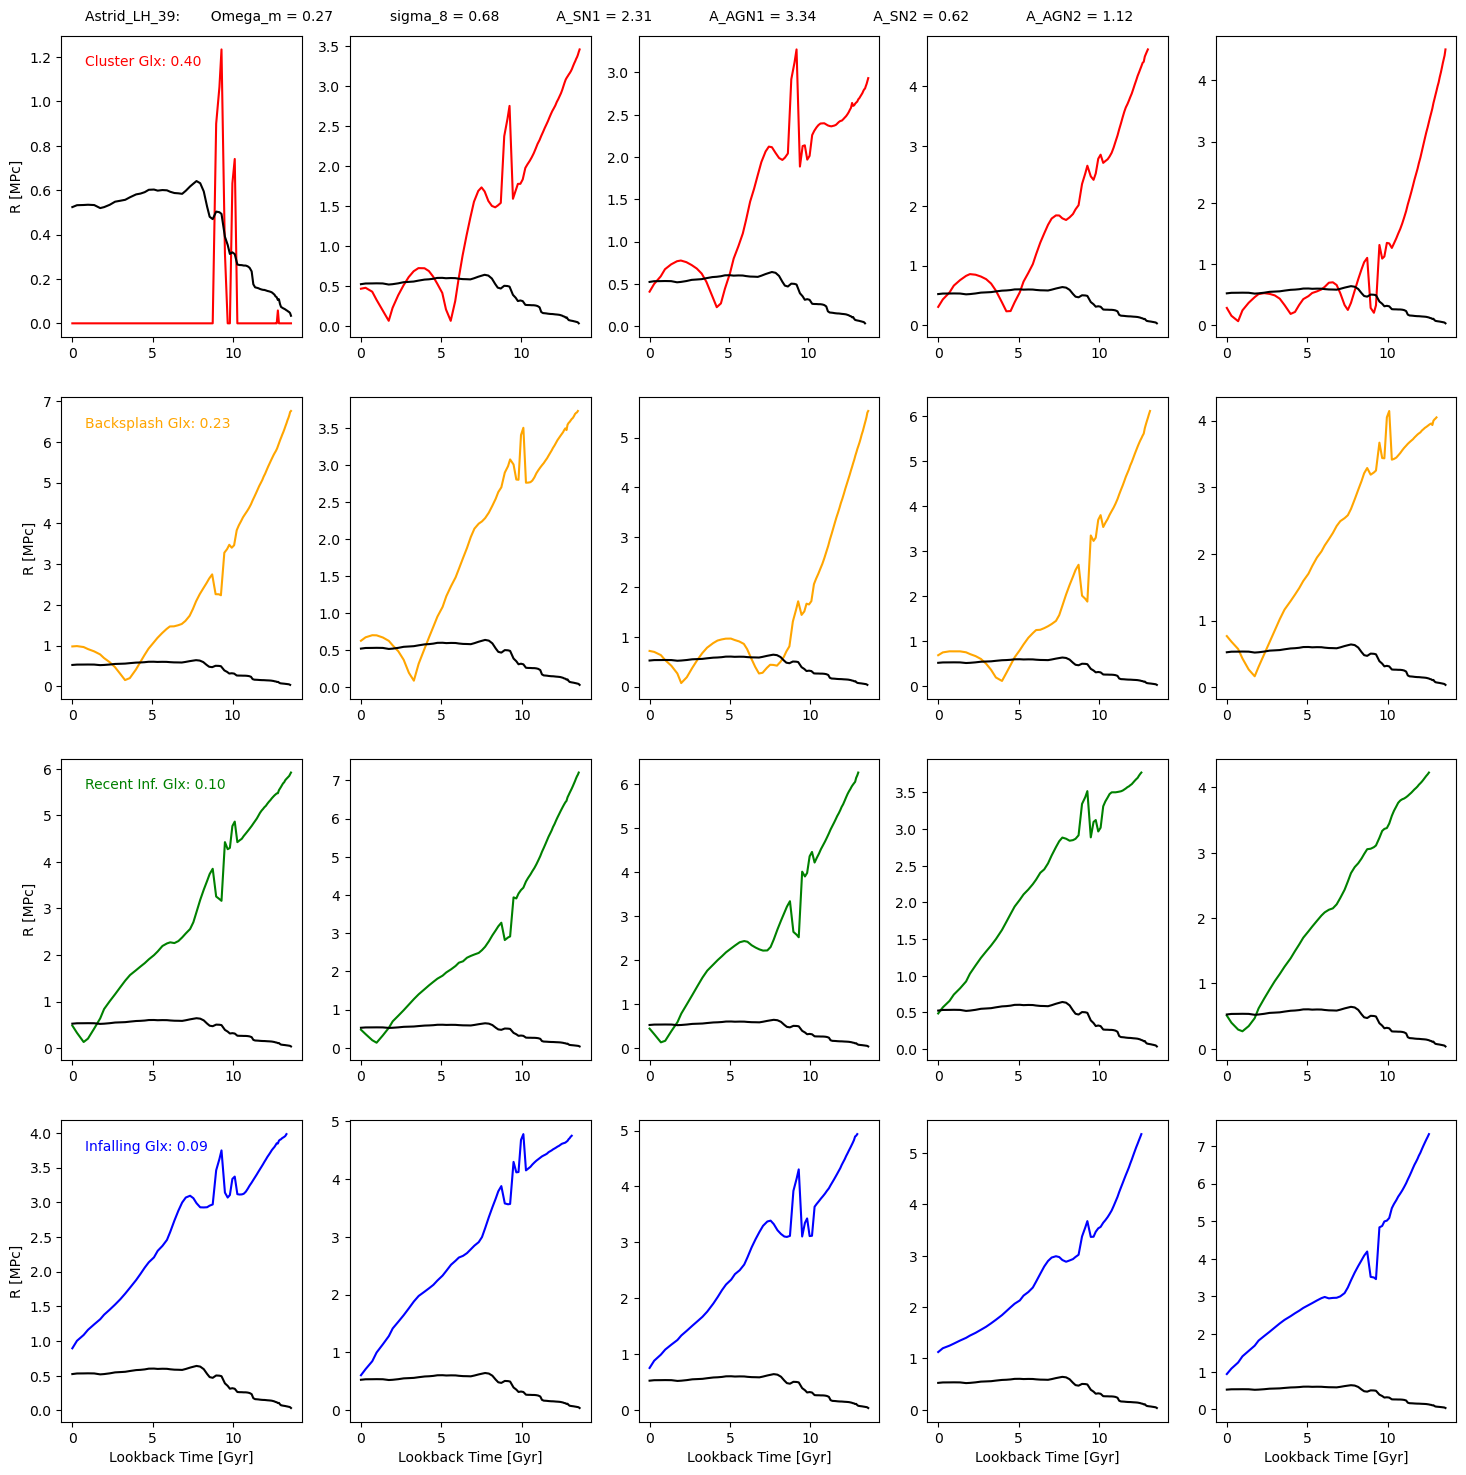

In [216]:
firstfofid = 'galID:' + str(halo_properties['haloID:0']['galaxies']['FirstSubhaloInFOFGroupID'])
snapshots_first = np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['snap'])
fig,ax = plt.subplots(4,5, figsize = (18,18))

for i, ind in enumerate(np.random.choice(cl_ind, np.min((5, len(cl_ind))))):
    galid = list(halo_properties['haloID:0']['galaxies'].keys())[cl_ind[i]]
    snapshots = np.array(halo_properties['haloID:0']['galaxies'][galid]['snap'])

    ax[0,i].plot(lookback[snapshots], np.array(halo_properties['haloID:0']['galaxies'][galid]['dist']), c = 'red')
    ax[0,i].plot(lookback[snapshots_first], np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['groupR200']), c = 'black')

for i, ind in enumerate(np.random.choice(bs_ind, np.min((5, len(bs_ind))))):
    galid = list(halo_properties['haloID:0']['galaxies'].keys())[bs_ind[i]]
    snapshots = np.array(halo_properties['haloID:0']['galaxies'][galid]['snap'])
    
    ax[1,i].plot(lookback[snapshots], np.array(halo_properties['haloID:0']['galaxies'][galid]['dist']), c = 'orange')
    ax[1,i].plot(lookback[snapshots_first], np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['groupR200']), c = 'black')

for i, ind in enumerate(np.random.choice(rin_ind, np.min((5, len(rin_ind))))):
    galid = list(halo_properties['haloID:0']['galaxies'].keys())[rin_ind[i]]
    snapshots = np.array(halo_properties['haloID:0']['galaxies'][galid]['snap'])
    
    ax[2,i].plot(lookback[snapshots], np.array(halo_properties['haloID:0']['galaxies'][galid]['dist']), c = 'green')
    ax[2,i].plot(lookback[snapshots_first], np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['groupR200']), c = 'black')

for i, ind in enumerate(np.random.choice(ot_ind, np.min((5, len(ot_ind))))):
    galid = list(halo_properties['haloID:0']['galaxies'].keys())[ot_ind[i]]
    snapshots = np.array(halo_properties['haloID:0']['galaxies'][galid]['snap'])
    
    ax[3,i].plot(lookback[snapshots], np.array(halo_properties['haloID:0']['galaxies'][galid]['dist']), c = 'blue')
    ax[3,i].plot(lookback[snapshots_first], np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['groupR200']), c = 'black')

    
ax[3,0].set_xlabel('Lookback Time [Gyr]')
ax[3,1].set_xlabel('Lookback Time [Gyr]')
ax[3,2].set_xlabel('Lookback Time [Gyr]')
ax[3,3].set_xlabel('Lookback Time [Gyr]')
ax[3,4].set_xlabel('Lookback Time [Gyr]')

ax[0,0].set_ylabel('R [MPc]')
ax[1,0].set_ylabel('R [MPc]')
ax[2,0].set_ylabel('R [MPc]')
ax[3,0].set_ylabel('R [MPc]')

ax[0,0].text(0.1,0.9, 'Cluster Glx: {:.2f}'.format(len(cl_ind) / (len(orb_class) - 1)), color = 'red', transform = ax[0,0].transAxes)
ax[1,0].text(0.1,0.9, 'Backsplash Glx: {:.2f}'.format(len(bs_ind) / (len(orb_class) - 1)), color = 'orange', transform = ax[1,0].transAxes)
ax[2,0].text(0.1,0.9, 'Recent Inf. Glx: {:.2f}'.format(len(rin_ind) / (len(orb_class) - 1)), color = 'green', transform = ax[2,0].transAxes)
ax[3,0].text(0.1,0.9, 'Infalling Glx: {:.2f}'.format(len(ot_ind) / (len(orb_class) - 1)), color = 'blue', transform = ax[3,0].transAxes)

ax[0,0].text(0.1,1.05, simu + '_LH_{}:       Omega_m = {:.2f}             sigma_8 = {:.2f}             A_SN1 = {:.2f}             A_AGN1 = {:.2f}             A_SN2 = {:.2f}             A_AGN2 = {:.2f}'.format(isim, params['Omega_m'][isim], params['sigma_8'][isim], params['A_SN1'][isim], params['A_AGN1'][isim], params['A_SN2'][isim], params['A_AGN2'][isim]), transform = ax[0,0].transAxes)

plt.savefig(simu + '_LH_' + str(isim) + '.pdf')